## 1. Initialize

In [31]:
from __future__ import unicode_literals

import csv
import json
import glob
import os
import re
import sys
import time
import requests
import traceback
from builtins import open
from time import sleep

from pprint import pprint as pp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import Image, display
import ipyplot

def cleaning_data():
    # 엑셀파일 열기
    data = pd.read_csv('org_ssgi.csv', encoding="utf-8", sep="|", na_filter= False, error_bad_lines=False)
    data = data[data['상권업종대분류명'] == '음식']
    frenchise_data = data[data['지점명']!=""]
    non_frenchise_data = data[data['지점명']==""]
    frenchise_data = frenchise_data.filter(items=['상가업소번호', '상호명', '지점명', '상권업종대분류명', '상권업종중분류명', '시군구명', '지번주소', '도로명주소', '경도', '위도'])
    non_frenchise_data = non_frenchise_data.filter(items=['상가업소번호', '상호명', '지점명', '상권업종대분류명', '상권업종중분류명', '시군구명', '지번주소', '도로명주소', '경도', '위도'])
    return frenchise_data, non_frenchise_data

def make_json(raw_csv):
    data = {}
    columnNameConvTable = {"상가업소번호":"id", "상호명": "restaurantName", "상권업종중분류명":"type", "시군구명":"subRegion", "지번주소":"adrDong", "도로명주소":"", "경도":"lat", "위도":"lon"}
    dup = 0    
    for idx, rows in raw_csv.iterrows():
        org_data = rows
        key = org_data['상호명']
        if key in data:
            dup += 1
        data[key] = {}
        for columnName in org_data.keys():
            if columnName not in columnNameConvTable:
                continue
            data[key][columnNameConvTable[columnName]] = org_data[columnName]
#     print("total", str(len(raw_csv)), "duplication", str(dup))
    return data
        
def save_json(file_name, json_data):
    with open(file_name, "w", encoding = 'utf8') as json_file:
        json.dump(json_data, json_file, indent=4, ensure_ascii=False)

def read_json(file_name):
    json_data = {}
    with open(file_name, encoding = 'utf8') as json_file:
        json_data = json.load(json_file)
    return json_data

def change_to_digit(like):
        if '.' in like:
            mul = 0
            if '천' in like:
                mul = 1000
            elif '만' in like:
                mul = 10000
            elif '백' in like:
                mul = 100
            like = float(like.strip('천만백')) * mul
        else:
            like = int(like.replace(',', ''))
        return like

def sortFunc(e):
    return e[1]

## 2. Split Frenchise and Non Frenchise

In [3]:
# 상호명끼리 분리하기
data, non_frenchise = cleaning_data()
print(len(data), len(non_frenchise))
# 비프렌차이즈 데이터 전처리
non_frenchise_data = {}
guList = ['강남구', '성북구', '중구', '은평구', '금천구', '광진구', '서대문구', '중랑구', '강북구', '관악구', '구로구', '영등포구', '마포구', '종로구', '도봉구', '용산구', '동작구', '서초구', '송파구', '노원구', '성동구', '양천구', '동대문구']
foodCategroy = ['닭/오리요리', '별식/퓨전요리', '분식', '양식', '일식/수산물', '제과제빵떡케익', '중식', '패스트푸드', '한식']
for gu in tqdm(guList):
    non_frenchise_data[gu] = {}
    for food in foodCategroy:
        csv_data = non_frenchise[(non_frenchise['시군구명'] == gu) & (non_frenchise['상권업종중분류명'] == food)]
        non_frenchise_data[gu][food] = make_json(csv_data)
save_json('[0]restaurant_list/non_frenchise_data.json',non_frenchise_data)        

# 프렌차이즈 데이터
sanghos = data.상호명.unique()
sanghos_data = {}
sangho_convertor = {}
print(len(sanghos))
sanghos = list(filter(lambda x : len(x) != 1, sanghos))
for sangho in tqdm(sanghos):
    sanghos_data[sangho] = 0
    for idx, fakesangho in enumerate(sanghos): 
        if sangho in fakesangho:
            sanghos_data[sangho] += 1
for sangho in tqdm(sanghos):
    for idx, fakesangho in enumerate(sanghos): 
        if sangho in fakesangho and sanghos_data[fakesangho] == 1:
            sanghos[idx] = sangho
            sangho_convertor[fakesangho] = sangho
sanghos = list(set(sanghos))

# 상호명으로 프랜차이즈를 구역끼리 묶기
frenchise_data = {}
for ho in tqdm(sanghos):
    medium_data = data[data['상호명'].str.contains(ho)]
    gus = medium_data.시군구명.unique()
    frenchise_data[ho] = {}
    frenchise_data[ho]['total_num'] = len(medium_data)
    types = medium_data.상권업종중분류명.unique()
    if len(types):
        frenchise_data[ho]['type'] = types[0]
    for gu in gus:
        gu_data = medium_data[medium_data['시군구명'] == gu]
        frenchise_data[ho][gu] = {"len":len(gu_data), "restaurants" : gu_data.to_dict('records')}

# CheckList
checkList = []
for restaurant_name in frenchise_data:
    if frenchise_data[restaurant_name]["total_num"] != 1:
        frenchise_data[restaurant_name]['name']=restaurant_name
        checkList.append(frenchise_data[restaurant_name])
save_json('[0]restaurant_list/checkList.json', checkList)    
save_json('[0]restaurant_list/frenchise_data.json', frenchise_data)
save_json('[0]restaurant_list/sanghos_data.json', sanghos_data)
save_json('[0]restaurant_list/frenchise_data_convertor.json', sangho_convertor)
print(len(checkList))

C:\Users\consi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

28428 100364


  0%|▎                                                                             | 50/14202 [00:00<00:58, 243.76it/s]

14211


100%|██████████████████████████████████████████████████████████████████████████████| 7101/7101 [03:32<00:00, 33.43it/s]


2726


## 3. Sort and Combine Franchise and Non Franchise

In [2]:
def sort():
    guList = ['강남구', '성북구', '중구', '은평구', '금천구', '광진구', '서대문구', '중랑구', '강북구', '관악구', '구로구', '영등포구', '마포구', '종로구', '도봉구', '용산구', '동작구', '서초구', '송파구', '노원구', '성동구', '양천구', '동대문구']
    foodCategroy = ['닭/오리요리', '별식/퓨전요리', '분식', '양식', '일식/수산물', '제과제빵떡케익', '중식', '패스트푸드', '한식']
    colors = ['000000', '3333CC', '00CC00', '00FFFF', '009999', '0099FF', '9933FF', '993300', 'FF9966', 'FF9900', 'CC6699', '99FF00', 'FFCCCC', '9966CC', '666600', 'CCFFCC', 'FFFF00', '999999', '996633', 'FF0066', '6699CC', 'CC6666', '663333', 'CCFF00', 'CCCC99']
    for gu, color in zip(guList, colors):
        print(gu)
        color = '#' + color
        foodRestaurantDict = {type : 0 for type in foodCategroy}
        for food in foodCategroy:
            popularList = []
            foodName = food.replace('/', '_')
            feed_data = list(read_json("[0]instagram_restaurant_feed_num/ssgi_data_search_result" + gu + "_" + foodName + ".json.json").values())
            restaurant_len = len(read_json("[0]restaurant_list/ssgi_data_" + gu + "_" + foodName + ".json"))
            for tag_info in feed_data:
                if gu == '동대문구' and food == '닭/오리요리':
                    popularList.append((tag_info['tag'], int(tag_info['feed_num'].replace(',', ''))))
                    foodRestaurantDict[food] += int(tag_info['feed_num'].replace(',', ''))
                else:
                    popularList.append((tag_info['tag'], int(tag_info['feed_num'].split(" ")[1].replace(',', ''))))
                    foodRestaurantDict[food] += int(tag_info['feed_num'].split(" ")[1].replace(',', ''))
            total = foodRestaurantDict[food]
            percent = total / restaurant_len
            popularList.sort(key=sortFunc, reverse=True)
            save_json("[1]sorted_instargram_restaurant_feed_num/sorted_"+gu + "_" + foodName + ".json", popularList)
            popularList = [elem + (str(round(elem[1]/total*100, 2))+"%",) for elem in popularList]
            print(f"{food} ({total}) 총 {len(feed_data)}개, 상위 10개의 비율({str(round(sum([round(elem[1]/total*100, 2) for elem in popularList[:10]])))}%)")
            pp(popularList[:10])
            print(f"{food} 는 총 {restaurant_len}개의 음식점이 있고 총 {total}개의 피드가 있다. ({percent})")
        plt.plot(foodRestaurantDict.values(), c=color)
    plt.show()

def combine(source_folder):
    managed_data = {}
    franchise_convert_table = read_json('[0]restaurant_list/frenchise_data_convertor.json')
    franchise_gu_table = read_json('[0]restaurant_list/frenchise_data.json')
#     guList = ['강남구', '성북구', '중구', '은평구', '금천구', '광진구', '서대문구', '중랑구', '강북구', '관악구', '구로구', '영등포구', '마포구', '종로구', '도봉구', '용산구', '동작구', '서초구', '송파구', '노원구', '성동구', '양천구', '동대문구']
    foodCategroy = ['닭/오리요리', '별식/퓨전요리', '분식', '양식', '일식/수산물', '제과제빵떡케익', '중식', '패스트푸드', '한식']
    guList = ['중구', '중랑구']
#     foodCategroy = ['분식', '닭/오리요리', '중식', '패스트푸드']
#     guList = ['중구']
#     foodCategroy = ['분식', '닭/오리요리', '중식', '패스트푸드']
    franchise_name_list = read_json('[0]restaurant_list/sanghos_data.json')
    non_frenchise_data = read_json('[0]restaurant_list/non_frenchise_data.json')
    statistic_json = {}
    for gu in guList:
        print(gu)
        managed_data[gu] = {}
        foodRestaurantDict = {type : 0 for type in foodCategroy}
        for food in foodCategroy:
            non_frenchise_restaurant_infos = non_frenchise_data[gu][food]
            per_gu_food_data = {"non_franchise":{}, "franchise":{}}
            foodName = food.replace('/', '_')
            feed_data = read_json(source_folder+'/sorted_'+gu+'_'+foodName+".json")
            # filter non franchise data 
            non_franchise_search_list = list(filter(lambda x : x[0] not in franchise_name_list, feed_data))
            non_franchise_search_len = len(non_franchise_search_list)
            # average feed per restaurant type
            non_franchise_average_feed = sum([x[1] for x in non_franchise_search_list]) / non_franchise_search_len
            # add restaurant info
            non_franchise_search_list = [{'name':name, 'val':val, 'restaurants': [non_frenchise_restaurant_infos[name]]} for name, val in non_franchise_search_list]
            # rank 50
            top_rank = non_franchise_search_len if non_franchise_search_len < 50 else 50
#             non_franchise_search_list = non_franchise_search_list[:top_rank]
            per_gu_food_data['non_franchise']['non_franchise_average_feed'] =  non_franchise_average_feed
            per_gu_food_data['non_franchise']['top_rank'] =  non_franchise_search_list
            # filter franchise data 
            franchise_search_list = list(filter(lambda x : x[0] in franchise_name_list and len(x[0]) > 1, feed_data))
            franchise_search_len = len(franchise_search_list)
            # convert franchise name to brand name
            franchise_search_dict = {name : 0 for name, num in franchise_search_list}
            for franchise in franchise_search_list:
                converted_name = franchise[0]
                ratio = 1
                # 다른 태그로 검색한 경우 Ex) 스타벅스 00점
                if converted_name in franchise_convert_table:
                    franchise_search_dict.pop(converted_name)
                    converted_name = franchise_convert_table[franchise[0]]
                # 검색한 태그가 본점인 경우 EX) 스타벅스
                elif converted_name in franchise_gu_table:
                    brand = franchise_gu_table[converted_name]
                    if gu in brand:
                        ratio = (float)(1)/brand['total_num']
                # 변경한 태그가 franchise에 없는 경우(없을리 만무하겠지만)
                if converted_name not in franchise_search_dict:
                    franchise_search_dict[converted_name] = 0
                franchise_search_dict[converted_name] += franchise[1] * ratio
            # average feed per restaurant type
            franchise_search_len = len(list(franchise_search_dict.keys()))
            franchise_search_dict = [{"name":name,"val":val} for name, val in franchise_search_dict.items()]
            franchise_average_feed = sum([item['val'] for item in franchise_search_dict]) / franchise_search_len
            # rank 50
            top_rank = franchise_search_len if franchise_search_len < 50 else 50
            franchise_search_dict.sort(key=lambda x : x['val'], reverse=True)
#             franchise_search_dict = franchise_search_dict[:top_rank]
            # add restaurant info
            for restaurant_dict in franchise_search_dict:
                if restaurant_dict["name"] in franchise_gu_table and gu in franchise_gu_table[restaurant_dict["name"]]:
                    restaurant_dict["restaurants"] = franchise_gu_table[restaurant_dict["name"]][gu]['restaurants']
            per_gu_food_data['franchise']['franchise_average_feed'] =  franchise_average_feed
            per_gu_food_data['franchise']['top_rank'] =  franchise_search_dict
            managed_data[gu][food] = per_gu_food_data
            if food not in statistic_json:
                statistic_json[food] = {}
            statistic_json[food][gu] = franchise_average_feed + non_franchise_average_feed
    
    save_json("[3]top_average_data/result.json", managed_data)
    save_json("[3]top_average_data/market.json", statistic_json)
    
# sort()
# combine('[1]sorted_instargram_restaurant_feed_num')
combine('[2]fitered_sorted_restaurant_feed_num')

중구
중랑구


## 4. Doc2Vec

In [45]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

voca = set()
hashtags = []
feeds = []
gu_list = ['중구', '중랑구']
food_category = ['닭_오리요리', '별식_퓨전요리', '분식', '양식', '일식_수산물', '제과제빵떡케익', '중식', '패스트푸드', '한식']
for gu in gu_list:
    for food in food_category:
        json_data = read_json(f'restaurant_feed/{gu}_{food}_posts.json')
        json_data = [feed for feeds in json_data for feed in feeds]
        for feed in tqdm(json_data):
            like, reply = (feed['like_reply'][0], feed['like_reply'][1]) if len(feed['like_reply']) == 2 else (feed['like_reply'][0], 0)
            if isinstance(like, str):
                like = change_to_digit(like)
            if isinstance(reply, str):
                reply = change_to_digit(reply)
            if len(feed['origin_caption']) > 100:
                feed['origin_caption'] = feed['origin_caption'][:100]
            hashtag = [htag[1:] for htag in feed['hashtags']]
            voca.update(hashtag)
            hashtags.append(hashtag)
            feed['type']=food
            feeds.append(feed)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(hashtags)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

def get_recommend(feedID, top=10):
    restaurant_type = feeds[feedID]['type']
    inferred_vector = model.infer_vector(documents[feedID].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=500)
    return list(filter(lambda x : feeds[x]['type'] == restaurant_type, [index for index, sim in sims]))[:20]

def save_image(id, pic_url):
    with open(f'pic{id}.jpg', 'wb') as handle:
            response = requests.get(pic_url, stream=True)

            if not response.ok:
                print(response)

            for block in response.iter_content(1024):
                if not block:
                    break

                handle.write(block)
                
# Load image from local storage
def get_recommendation(feed_id):
    save_image("target", feeds[feed_id]['img_url'])
    display(Image(filename = "pictarget.jpg", width = 300, height = 300))
    image_array = []
    print(get_recommend(feed_id))
    for id in get_recommend(feed_id):
        save_image(id, feeds[id]['img_url'])
        plt.figure()
        image_array.append(f"pic{id}.jpg")
    ipyplot.plot_images(image_array, max_images=20, img_width=150)

100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 49639.70it/s]


In [46]:
len(list(voca))

8410

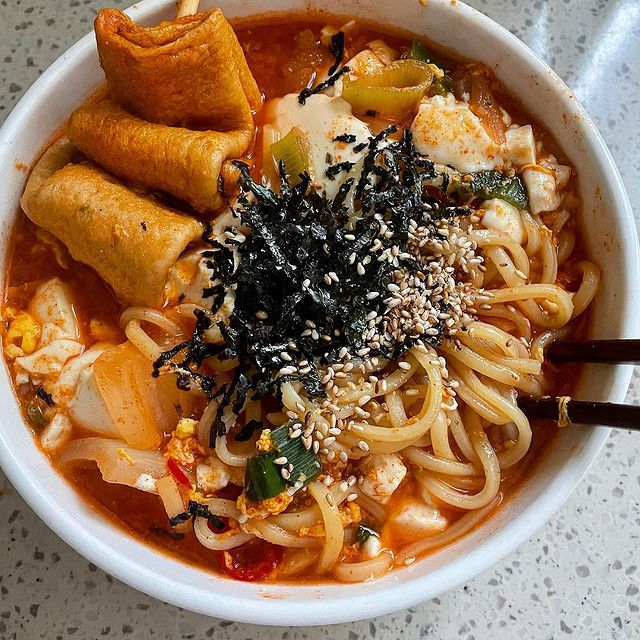

[916, 860, 123, 111, 889, 824, 883, 818, 873, 763, 806, 845, 107, 141, 886, 793, 896, 901, 892, 822]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [47]:
get_recommendation(800)